# Combi Grid turorial, from
https://sgpp.github.io/SGpp/example_combigrid_py.html

This makes a static sparce grid and shows the interpolant at a test point is better than a full grid interpolant at that test point

In [15]:
import pysgpp
import numpy as np
import sys
 
# skip plotting if Matplotlib cannot be imported (e.g., not installed or no GUI available)
try:
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  doPlot = True
except ImportError:
  doPlot = False
  
print('DO PLOT', doPlot)
  
def plotFunction(opEval, surpluses, X):
  if not doPlot: return
 
  # generate a meshgrid for plotting
  xx0 = np.linspace(0, 1, 65)
  xx1 = np.linspace(0, 1, 65)
  XX0, XX1 = np.meshgrid(xx0, xx1)
  XX = pysgpp.DataMatrix(np.column_stack([XX0.flatten(), XX1.flatten()]))
 
  # evaluate interpolant at meshgrid
  YY = pysgpp.DataVector(0)
  opEval.multiEval(surpluses, XX, YY)
 
  # convert resulting sgpp::base::DataVector to NumPy array
  YY = np.reshape(np.array([YY[k] for k in range(YY.getSize())]), XX0.shape)
 
  # actual plotting
  fig = plt.figure(figsize=(6, 6))
  ax = fig.add_subplot(projection="3d")
  ax.plot_surface(XX0, XX1, YY)
  ax.plot(X[:,0], X[:,1], "k.", zs=f(X[:,0], X[:,1]), ms=10)

DO PLOT True


We define some parameters such as dimensionality and level of the regular sparse grid.

In [16]:
# dimensionality
dim = 2
# regular level
n = 4
# B-spline degree
p = 3
# whether there are points on the boundary
hasBoundary = False
# test function
f = lambda XX0, XX1: np.sin(7*XX0-3)*np.cos(5*XX1-5)
 
# disable log output
pysgpp.Printer.getInstance().setVerbosity(-1)

The basis functions are defined via an sgpp::combigrid::HeterogeneousBasis object. In contrast to sgpp::base::Basis, this allows for different types of basis functions for the different dimensions. However, for this example, we do not need this flexibility, so we use the same basis function types for both dimensions.

In [17]:
basis1d = pysgpp.SBsplineBase(p)
basis = pysgpp.HeterogeneousBasis(dim, basis1d)

An sgpp::combigrid::CombinationGrid is a collection of full grids (nodal subspaces) together with scalar-valued coefficients. Here, we construct an sgpp::combigrid::CombinationGrid object for a regular sparse grid via the combination technique.

In [18]:
combiGrid = pysgpp.CombinationGrid.fromRegularSparse(dim, n, basis, hasBoundary)

We obtain the grid points of the regular sparse grid by combining the grid points of all full grids that are contained in the combination grid.

In [19]:
gridStorage = pysgpp.HashGridStorage(dim)
combiGrid.combinePoints(gridStorage)
 
# convert grid storage to array with coordinates of grid points
X = np.array([[gridStorage.getPoint(k).getStandardCoordinate(d) for d in range(dim)]
              for k in range(gridStorage.getSize())])
 
# evaluate test function at grid points
fX = pysgpp.DataVector(f(X[:,0], X[:,1]))

We now want to perform an operation on each full grid. For this, we distribute the values of the combined grid (sparse grid) to the full grids. The result is a std::vector of sgpp::base::DataVector; each DataVector contains the values at all grid points for one specific full grid.

In [20]:
values = pysgpp.DataVectorVector()
combiGrid.distributeValuesToFullGrids(gridStorage, fX, values)

The operation we want to perform on each full grid is hierarchization. Since the grids are full grids, we can use the unidirectional principle for this, which performs 1D hierarchization on each pole (one-dimensional sub-grid), iterating over all dimensions.

In [21]:
# copy the values (surpluses will be modified in-place)
surpluses = pysgpp.DataVectorVector(values)
 
# create pole operation
opPole = pysgpp.OperationPoleVector()
pysgpp.OperationPoleHierarchisationGeneral.fromHeterogenerousBasis(basis, opPole)
 
# create operation for unidirectional principle and hierarchize in-place
opHier = pysgpp.OperationUPCombinationGrid(combiGrid, opPole)
opHier.apply(surpluses)

The resulting surpluses are also a std::vector of sgpp::base::DataVector, separated by full grids. We could combine the full grid surpluses via the combination formula to the sparse grid surpluses via combineSparseGridValues. However, the operation sgpp::combigrid::OperationEvalCombinationGrid does this automatically.

We evaluate the combined function (combination of all full grid interpolants) at some arbitrary point, print the value, and plot the function.

Value of test function at [0.12 0.34]: 0.820974
Value of combined sparse grid interpolant at [0.12 0.34]: -84.4795


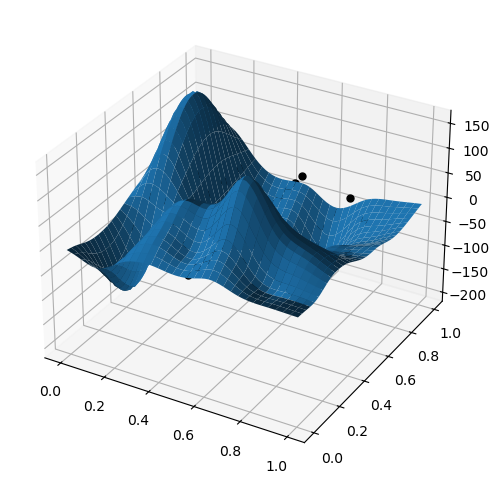

In [22]:
# test point at which to evaluate
x = [0.12, 0.34]
xDv = pysgpp.DataVector(x)
print("Value of test function at {}: {:.6g}".format(np.array(x), f(*x)))
# create operation for evaluating and evaluate
opEval = pysgpp.OperationEvalCombinationGrid(combiGrid)
y = opEval.eval(surpluses, xDv)
print("Value of combined sparse grid interpolant at {}: {:.6g}".format(np.array(x), y))
# plot
plotFunction(opEval, surpluses, X)

Finally, we do the same for one full grid of the combination grid: We evaluate and plot the corresponding interpolant. We extract the surpluses from the already calculated vector of DataVector. Alternatively, we could also apply sgpp::combigrid::OperationUPFullGrid with opPole to obtain the surpluses for this single full grid.

Level of selected full grid with index 1: [3 2]
Value of full grid interpolant at [0.12 0.34]: -62.6639


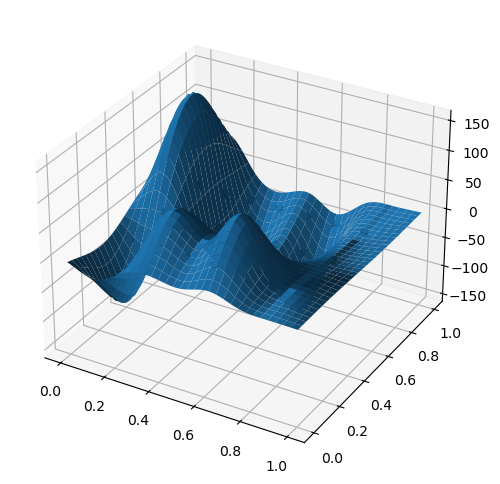

In [23]:
# select the second full grid of the combination grid (arbitrary choice)
fullGridIndex = 1
fullGrid = combiGrid.getFullGrids()[fullGridIndex]
l = fullGrid.getLevel()
print("Level of selected full grid with index {}: {}".format(fullGridIndex, np.array(l)))
 
# create operation for evaluating and evaluate
opEval = pysgpp.OperationEvalFullGrid(fullGrid)
y = opEval.eval(surpluses[fullGridIndex], xDv)
print("Value of full grid interpolant at {}: {:.6g}".format(np.array(x), y))
 
# compute grid points of full grid
X = pysgpp.DataMatrix(0, 0)
pysgpp.IndexVectorRange.getPoints(fullGrid, X)
 
# convert resulting sgpp::base::DataMatrix to NumPy array
X = np.array([[X.get(k, j) for j in range(X.getNcols())] for k in range(X.getNrows())])
 
# plot
plotFunction(opEval, surpluses[fullGridIndex], X)
 
if doPlot: plt.show()
else: print("Skipping plots due to failed import of Matplotlib.")

The example program outputs the following results:

Value of test function at [0.12 0.34]: 0.820974
Value of combined sparse grid interpolant at [0.12 0.34]: 0.774666
Level of selected full grid with index 1: [3 1]
Value of full grid interpolant at [0.12 0.34]: 0.564036

We see that the value of the combined sparse grid interpolant at the evaluation point is closer to the actual value of the test function than the value of the chosen full grid interpolant, which corresponds to the full grid of level (3,1).

